In [5]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [6]:
!pip install transformers einops scikit-learn pandas matplotlib tqdm


In [7]:
from transformers import AutoTokenizer, AutoModel
import torch
import pandas as pd
import random
import numpy as np
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


In [8]:
model_name = "LongSafari/hyenadna-small-32k-seqlen-hf"

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
model = AutoModel.from_pretrained(model_name, trust_remote_code=True)
model.eval()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.48k [00:00<?, ?B/s]

tokenization_hyena.py:   0%|          | 0.00/4.06k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/LongSafari/hyenadna-small-32k-seqlen-hf:
- tokenization_hyena.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


special_tokens_map.json:   0%|          | 0.00/971 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/981 [00:00<?, ?B/s]

configuration_hyena.py:   0%|          | 0.00/3.09k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/LongSafari/hyenadna-small-32k-seqlen-hf:
- configuration_hyena.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_hyena.py:   0%|          | 0.00/22.6k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/LongSafari/hyenadna-small-32k-seqlen-hf:
- modeling_hyena.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/16.3M [00:00<?, ?B/s]

HyenaDNAModel(
  (backbone): HyenaLMBackbone(
    (embeddings): HyenaEmbeddings(
      (word_embeddings): Embedding(16, 256)
    )
    (dropout): Dropout(p=0.1, inplace=False)
    (layers): ModuleList(
      (0-3): 4 x HyenaBlock(
        (mixer): HyenaOperator(
          (dropout): Dropout(p=0.0, inplace=False)
          (in_proj): Linear(in_features=256, out_features=768, bias=True)
          (out_proj): Linear(in_features=256, out_features=256, bias=True)
          (short_filter): Conv1d(768, 768, kernel_size=(3,), stride=(1,), padding=(2,), groups=768)
          (filter_fn): HyenaFilter(
            (dropout): Dropout(p=0.0, inplace=False)
            (pos_emb): HyenaPositionalEmbedding()
            (implicit_filter): Sequential(
              (0): Linear(in_features=5, out_features=64, bias=True)
              (1): HyenaSin()
              (2): Linear(in_features=64, out_features=64, bias=True)
              (3): HyenaSin()
              (4): Linear(in_features=64, out_features=6

In [9]:
csv_path = '/content/drive/MyDrive/genomics_project/data/benchmark3_language_modeling.csv'
df = pd.read_csv(csv_path)
df = df.dropna()
real_sequences = df['sequence'].tolist()


In [13]:
def shuffle_dna(seq):
    seq_list = list(seq)
    random.shuffle(seq_list)
    return ''.join(seq_list)


In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

accuracies = []
f1_scores = []
roc_aucs = []

for seed in [0, 1, 2, 3, 4]:
    print(f"\n=== Run {seed+1} ===")
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    real_seqs = real_sequences[:100]
    shuffled_seqs = [shuffle_dna(seq) for seq in real_seqs]
    X = real_seqs + shuffled_seqs
    y = [1]*100 + [0]*100

    # Compute embeddings using HyenaDNA
    embeddings = []
    for seq in X:
        inputs = tokenizer(seq, return_tensors="pt", truncation=True, padding="max_length", max_length=1024)
        with torch.no_grad():
            outputs = model(**inputs)
        pooled = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
        embeddings.append(pooled)

    embeddings = np.array(embeddings)
    X_train, X_test, y_train, y_test = train_test_split(embeddings, y, test_size=0.2, random_state=seed)

    # I use Logistic regression to classify the embeddings
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    accuracies.append(acc)
    f1_scores.append(f1)
    roc_aucs.append(auc)

    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {auc:.4f}")



=== Run 1 ===
Accuracy: 0.7000
F1 Score: 0.6000
ROC AUC: 0.7424

=== Run 2 ===
Accuracy: 0.7000
F1 Score: 0.6842
ROC AUC: 0.7570

=== Run 3 ===
Accuracy: 0.7250
F1 Score: 0.7317
ROC AUC: 0.8698

=== Run 4 ===
Accuracy: 0.7000
F1 Score: 0.6667
ROC AUC: 0.7323

=== Run 5 ===
Accuracy: 0.7500
F1 Score: 0.6429
ROC AUC: 0.6843


## Avergae of 5 Runs for HyenaDNA

In [15]:
print("\n=== Final Averages ===")
print("Average Accuracy:", round(sum(accuracies)/len(accuracies), 4))
print("Average F1 Score:", round(sum(f1_scores)/len(f1_scores), 4))
print("Average ROC AUC:", round(sum(roc_aucs)/len(roc_aucs), 4))



=== Final Averages ===
Average Accuracy: 0.715
Average F1 Score: 0.6651
Average ROC AUC: 0.7572


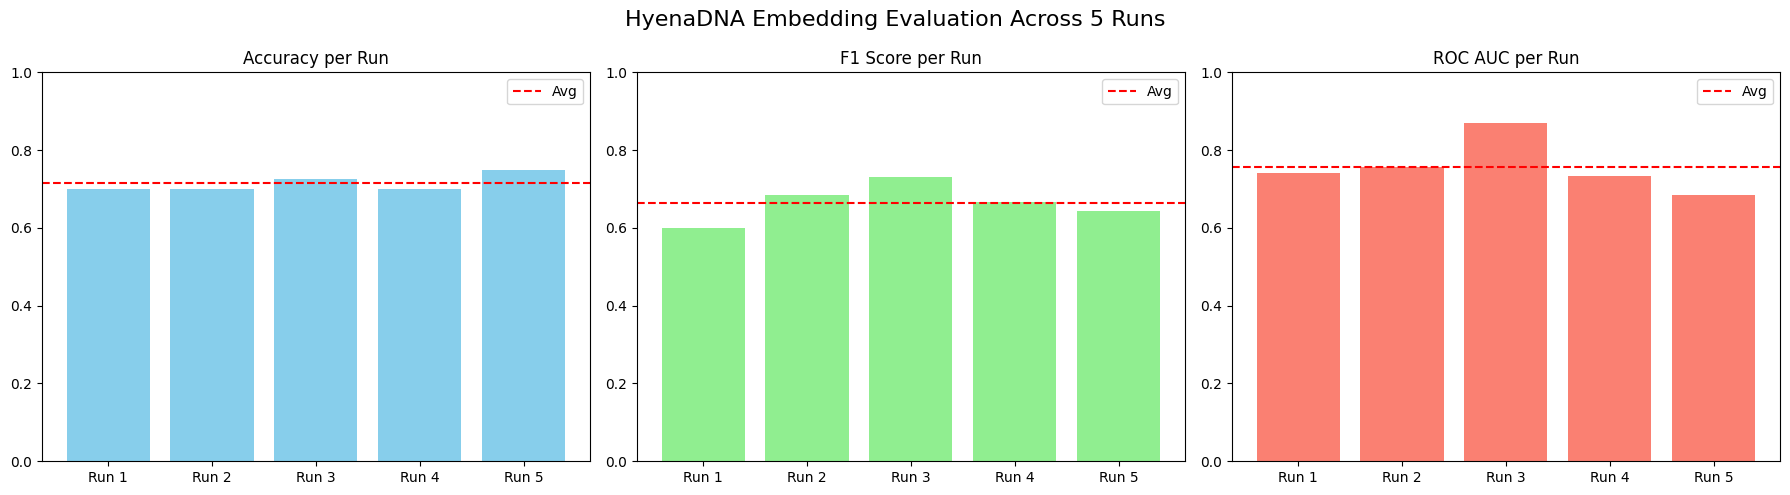

In [16]:
runs = [f"Run {i+1}" for i in range(5)]

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

axs[0].bar(runs, accuracies, color='skyblue')
axs[0].axhline(y=sum(accuracies)/len(accuracies), color='red', linestyle='--', label='Avg')
axs[0].set_title('Accuracy per Run')
axs[0].set_ylim(0, 1)
axs[0].legend()

axs[1].bar(runs, f1_scores, color='lightgreen')
axs[1].axhline(y=sum(f1_scores)/len(f1_scores), color='red', linestyle='--', label='Avg')
axs[1].set_title('F1 Score per Run')
axs[1].set_ylim(0, 1)
axs[1].legend()

axs[2].bar(runs, roc_aucs, color='salmon')
axs[2].axhline(y=sum(roc_aucs)/len(roc_aucs), color='red', linestyle='--', label='Avg')
axs[2].set_title('ROC AUC per Run')
axs[2].set_ylim(0, 1)
axs[2].legend()

fig.suptitle('HyenaDNA Embedding Evaluation Across 5 Runs', fontsize=16)
plt.tight_layout()
plt.show()
